###### Описание задачи

Входные данные - [биржевой стакан](https://en.wikipedia.org/wiki/Order_book_(trading)) некоторого актива. Он содержит в себе ценовые уровни и объемы заявок на уровне. Глубина стакана - 5.  
В данных приведён стакан на каждый тик биржи.  
ask_rate - цены заявок на продажу  
ask_amount - объёмы заявок на продажу  
bid_rate - цены заявок на покупку  
bid_amount - объёмы заявок на покупку

На каждый тик определим цену актива. Возьмём среднее между наименьшим ask_rate (askbest) и наибольшим bid_rate (bidbest) в момент времени t:  
$$ midprice(t) = (askbest(t) + bidbest(t)) / 2 $$  

Определим целевую переменную. Будем прогнозировать изменение midprice через четыре тика (в момент времени t + 4):
$$ target(t) = midprice(t + 4) - midprice(t) $$ 

**Цель тестового задания - решить задачу регрессии.**  

Данные находятся в двух файлах.  
train.csv - данные для обучения и валидации модели  
test.csv - данные для финальной оценки качества модели  

#### Идеи для признаков:
- суммарный объем заявок в стакане
- дисбаланс объемов всех заявок на продажу и всех заявок на покупку
- разница между лучшей ценой на продажу и лучшей ценой на покупку  
- волатильность цены за период  
- цена n тиков назад

#### Критерии оценки: 
- структура построения пайплайна обучения модели    
- качество кода  
- точность прогноза по метрике RMSE на данных из test.csv 

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

In [2]:
df = pd.read_pickle('train.pkl')
test = pd.read_pickle('test.pkl')

In [3]:
# df.iloc[-7000:].bid_rate.apply(lambda x: max(x)).plot()
# df.iloc[-7000:].ask_rate.apply(lambda x: min(x)).plot()

In [ ]:
df['best_bid_rate'] = df.bid_rate.apply(lambda x: max(x))
df['best_ask_rate'] = df.ask_rate.apply(lambda x: min(x))
df['sum_amount'] = df.bid_amount.apply(lambda x: np.array(x).sum()) + df.ask_amount.apply(lambda x: np.array(x).sum())
df['razn_amount'] = df.bid_amount.apply(lambda x: np.array(x).sum()) - df.ask_amount.apply(lambda x: np.array(x).sum())
df['razn_best_amounts'] = df.bid_amount.apply(lambda x: max(x)) - df.ask_amount.apply(lambda x: min(x))
df['mean_bid_rate'] = df.bid_rate.apply(lambda x: np.mean(np.array(x)))
df['mean_ask_rate'] = df.ask_rate.apply(lambda x: np.mean(np.array(x)))
arr1 = []
arr2 = []
price_n = []
for i in tqdm(range (0, 120000)):
    price_n.append(df.iloc[i-50].midprice)
    cur1 = df.iloc[i-50:i].bid_rate.values
    cur2 = df.iloc[i-50:i].ask_rate.values
#     print(cur)
#     break
    x1 = []
    x2 = []
    for c in cur1:
        x1 = np.concatenate((x1, c))
    arr1.append(np.std(x1))
    for c in cur2:
        x2 = np.concatenate((x2, c))
    arr2.append(np.std(x2))
# df = df[50:]
df['std_bid'] = arr1
df['std_ask'] = arr2
df['price_n'] = price_n
df.head()
# sm.graphics.tsa.plot_acf(df.iloc[-3000:].ask_rate.apply(lambda x: min(x)).values)

  0%|          | 0/120000 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 84%|████████▎ | 100350/120000 [01:34<00:16, 1189.95it/s]

In [ ]:
test = pd.read_pickle('test.pkl')
test['best_bid_rate'] = test.bid_rate.apply(lambda x: max(x))
test['best_ask_rate'] = test.ask_rate.apply(lambda x: min(x))
test['sum_amount'] = test.bid_amount.apply(lambda x: np.array(x).sum()) + test.ask_amount.apply(lambda x: np.array(x).sum())
test['razn_amount'] = test.bid_amount.apply(lambda x: np.array(x).sum()) - test.ask_amount.apply(lambda x: np.array(x).sum())
test['razn_best_amounts'] = test.bid_amount.apply(lambda x: max(x)) - test.ask_amount.apply(lambda x: min(x))
test['mean_bid_rate'] = test.bid_rate.apply(lambda x: np.mean(np.array(x)))
test['mean_ask_rate'] = test.ask_rate.apply(lambda x: np.mean(np.array(x)))
arr1 = []
arr2 = []
price_n = []
for i in tqdm(range (0, 30000)):
    cur1 = test.iloc[i-50:i].bid_rate.values
    cur2 = test.iloc[i-50:i].ask_rate.values
    price_n.append(df.iloc[i-50].midprice)
#     print(cur)
#     break
    x1 = []
    x2 = []
    for c in cur1:
        x1 = np.concatenate((x1, c))
    arr1.append(np.std(x1))
    for c in cur2:
        x2 = np.concatenate((x2, c))
    arr2.append(np.std(x2))
# df = df[50:]
test['std_bid'] = arr1
test['std_ask'] = arr2
test['price_n'] = price_n
test.head()
# sm.graphics.tsa.plot_acf(df.iloc[-3000:].ask_rate.apply(lambda x: min(x)).values)

In [ ]:
target = df.target.values
df = df.drop(columns="target")
df['target'] = target
dff = df.copy()[50:]

target = dff.target.values
midprice = dff.midprice.values

dff = dff.drop(["ask_rate", "bid_rate", "ask_amount", "bid_amount", "target", "midprice"], axis=1)
dff.head

In [ ]:
target1 = test.target.values
test = test.drop(columns="target")
test['target'] = target1
test1 = test.copy()[50:]

target1 = test1.target.values
midprice1 = test1.midprice.values

test1 = test1.drop(["ask_rate", "bid_rate", "ask_amount", "bid_amount", "midprice", "target"], axis=1)
test1.head

In [ ]:
shift_size = 50

X_train_bid = []
y_train_bid = []
X_train_ask = []
y_train_ask = []

X_test_bid = []
y_test_bid = []
X_test_ask = []
y_test_ask = []



# dff = dff.reset_index()
for i in tqdm(range(shift_size, len(dff)-3)):
    X_train_bid.append(dff.iloc[i-shift_size:i].values.ravel())
    y_train_bid.append(dff.best_bid_rate[i + 3])
    X_train_ask.append(dff.iloc[i-shift_size:i].values.ravel())
    y_train_ask.append(dff.best_ask_rate[i + 3])
    
for i in tqdm(range(shift_size, len(test1)-3)):
    X_test_bid.append(test1.iloc[i-shift_size:i].values.ravel())
    y_test_bid.append(test1.best_bid_rate[i + 3])
    X_test_ask.append(test1.iloc[i-shift_size:i].values.ravel())
    y_test_ask.append(test1.best_ask_rate[i + 3])

# print(X_train[0])
# print(y_train[0])
# X_train, y_train = np.array(X_train), np.array(y_train)
# print(X_train)
# print(y_train)

In [ ]:
dff.shape, test1.shape

In [ ]:
# print(X_train[0])

In [ ]:
X_train_bid, y_train_bid = np.array(X_train_bid), np.array(y_train_bid)
X_train_ask, y_train_ask = np.array(X_train_ask), np.array(y_train_ask)

In [ ]:
X_test_bid, y_test_bid = np.array(X_test_bid), np.array(y_test_bid)
X_test_ask, y_test_ask = np.array(X_test_ask), np.array(y_test_ask)

In [ ]:
print(X_train_bid.shape)
print(X_test_bid.shape)

In [ ]:
lr = LinearRegression()
lr.fit(X_train_bid, y_train_bid)
# print(X_train_bid.shape)
prediction = lr.predict(X_test_bid)

lr1 = LinearRegression()
lr1.fit(X_train_ask, y_train_ask)
prediction1 = lr1.predict(X_test_ask)

print(sqrt(mean_squared_error(prediction, y_test_bid)))
print(sqrt(mean_squared_error(prediction1, y_test_ask)))

In [ ]:
pred_mid = []
for a, b in zip(prediction, prediction1):
    pred_mid.append((a + b) / 2)
pred_target = []
# len(pred_mid)
for i in range(len(pred_mid)):
    pred_target.append(pred_mid[i + 4] - pred_mid[i]) if(i + 4 < len(pred_mid)) else pred_target.append(0)
len(pred_target)

In [ ]:
midprice1.shape
mp = np.array(midprice1)
len(mp[50:-3])

In [ ]:
sqrt(mean_squared_error(pred_target, target1[50:-3]))

In [ ]:
target1.shape

In [ ]:
sqrt(mean_squared_error(np.array(target1), np.zeros(29950)))

In [ ]:
import xgboost as xgb

def boosting(X_train_bid, y_train_bid, X_test_bid, y_test_bid):
    dtrain = xgb.DMatrix(X_train_bid, label=y_train_bid)
    dtest = xgb.DMatrix(X_test_bid)
    return 0
    params = {
            'objective': 'reg:linear',
            'booster':'gblinear'
        }
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    prediction_train = bst.predict(dtrain)

    prediction_test = bst.predict(dtest)

    print(sqrt(mean_squared_error(prediction_test, y_test_bid)))

In [ ]:
boosting(X_train_bid[:1000], y_train_bid[:1000], X_test_bid[:1000], y_test_bid[:1000])

In [54]:
from math import sqrt

def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = sqrt(metrics(model.predict(X_testFold), y_testFold))

    # the function returns the mean of the errors on the n-1 folds    
    return (errors.mean())

In [55]:
lr = LinearRegression()
print(performTimeSeriesCV(X_train_bid, y_train_bid, 5, lr, mean_squared_error))
lr = LinearRegression()
print(performTimeSeriesCV(X_train_ask, y_train_ask, 5, lr, mean_squared_error))

Size train set: (119897, 500)
Size of each fold: 23979

Splitting the first 2 chunks at 1/2
Size of train + test: (47958, 500)

Splitting the first 3 chunks at 2/3
Size of train + test: (71937, 500)

Splitting the first 4 chunks at 3/4
Size of train + test: (95916, 500)

Splitting the first 5 chunks at 4/5
Size of train + test: (119895, 500)
19.313668612070217
Size train set: (119897, 500)
Size of each fold: 23979

Splitting the first 2 chunks at 1/2
Size of train + test: (47958, 500)

Splitting the first 3 chunks at 2/3
Size of train + test: (71937, 500)

Splitting the first 4 chunks at 3/4
Size of train + test: (95916, 500)

Splitting the first 5 chunks at 4/5
Size of train + test: (119895, 500)
19.211672163073175


In [135]:
X_train = dff.loc[:100000].drop(["best_bid_rate"], axis=1)
y_train = dff.loc[:100000]["best_bid_rate"]
X_test = dff.loc[100000:].drop(["best_bid_rate"], axis=1)
y_test = dff.loc[100000:]["best_bid_rate"]

X_train1 = dff.loc[:100000].drop(["best_ask_rate"], axis=1)
y_train1 = dff.loc[:100000]["best_ask_rate"]
X_test1 = dff.loc[100000:].drop(["best_ask_rate"], axis=1)
y_test1 = dff.loc[100000:]["best_ask_rate"]


lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

lr1 = LinearRegression()
lr1.fit(X_train1, y_train1)
prediction1 = lr1.predict(X_test1)

pred_mid = []
for a, b in zip(prediction, prediction1):
    pred_mid.append((a + b) / 2)
pred_target = []
for i in range(len(pred_mid)):
    pred_target.append(pred_mid[i + 4] - pred_mid[i]) if(i + 4 < len(pred_mid)) else pred_target.append(0)
print(mean_absolute_error(pred_mid[:-4], midprice[99950:-4]))
print(mean_absolute_error(pred_target[:-4], target[99950:-4]))
    
# plt.figure(figsize=(15, 7))
# plt.plot(prediction, "r", label="prediction")
# plt.plot(y_test.values, label="actual")
# plt.plot(prediction1, "r", label="prediction")
# plt.plot(y_test1.values, label="actual")
# plt.legend(loc="best")
# plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
# plt.grid(True);

0.15636595328751643
0.20915392071818506


In [130]:
print(performTimeSeriesCV(X_train, y_train, 5, lr, mean_squared_error))
print(performTimeSeriesCV(X_train1, y_train1, 5, lr1, mean_squared_error))

Size train set: (119950, 8)
Size of each fold: 23990

Splitting the first 2 chunks at 1/2
Size of train + test: (47980, 8)

Splitting the first 3 chunks at 2/3
Size of train + test: (71970, 8)

Splitting the first 4 chunks at 3/4
Size of train + test: (95960, 8)

Splitting the first 5 chunks at 4/5
Size of train + test: (119950, 8)
1.1687379995450577
Size train set: (119950, 8)
Size of each fold: 23990

Splitting the first 2 chunks at 1/2
Size of train + test: (47980, 8)

Splitting the first 3 chunks at 2/3
Size of train + test: (71970, 8)

Splitting the first 4 chunks at 3/4
Size of train + test: (95960, 8)

Splitting the first 5 chunks at 4/5
Size of train + test: (119950, 8)
1.168525375168731


120000it [00:28, 4225.41it/s]


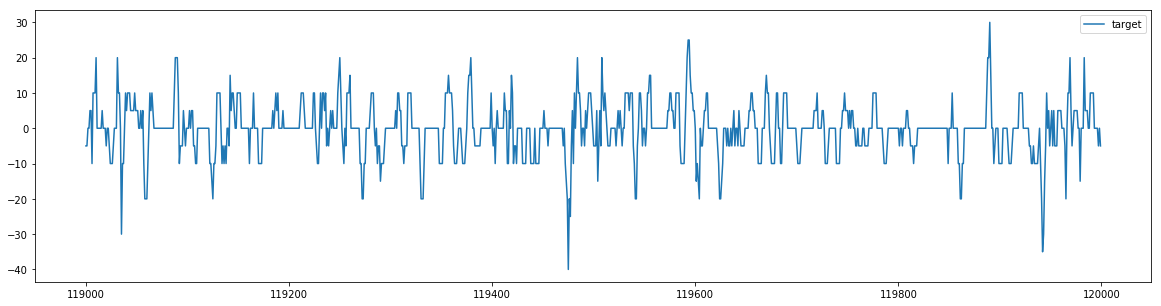

In [50]:
# df.iloc[0]['ask_rate']
from tqdm import tqdm
df1 = pd.DataFrame()

sum_amounts = []
dis_balance = []
best_price_razn = []
target = []

for index, row in tqdm(df.iterrows()):
    sum_amounts.append(np.sum(row['ask_amount']) + np.sum(row['bid_amount']))
    dis_balance.append(np.sum(row['ask_amount']) - np.sum(row['bid_amount']))
    best_price_razn.append(np.max(row['ask_rate']) - np.max(row['bid_rate']))
    target.append(row['target'])
# df1['sum_amount'] = sum_amounts
# df1['dis_balance'] = dis_balance
# df1['best_price_razn'] = best_price_razn
df1['target'] = target
df1[-1000:].plot()

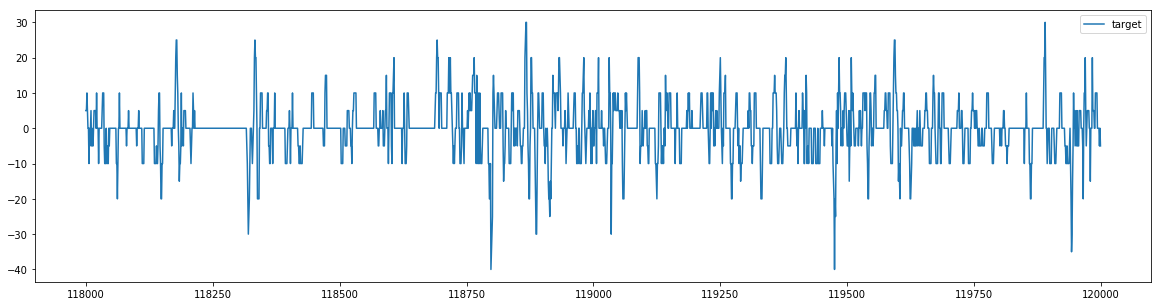

In [53]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 5
df1[-2000:].plot()

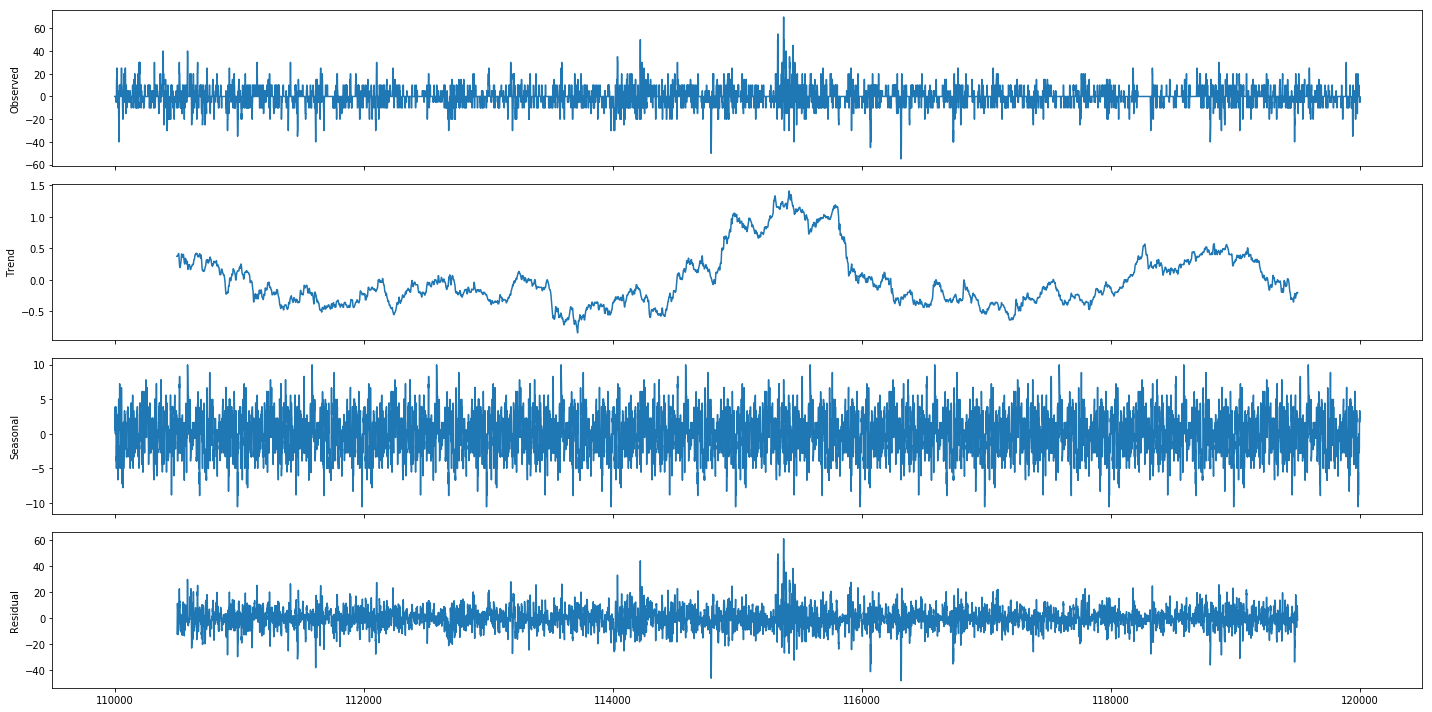

In [65]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
rcParams['figure.figsize'] = 20, 10
result = sm.tsa.seasonal_decompose(df1[-10000:], model='additive', freq=1000)
result.plot()
plt.show()

In [16]:
test.head

<bound method NDFrame.head of                                                 ask_rate  \
0      [103210.0, 103220.0, 103230.0, 103240.0, 10325...   
1      [103210.0, 103220.0, 103230.0, 103240.0, 10325...   
2      [103210.0, 103220.0, 103230.0, 103240.0, 10325...   
3      [103210.0, 103220.0, 103230.0, 103240.0, 10325...   
4      [103210.0, 103220.0, 103230.0, 103240.0, 10325...   
...                                                  ...   
29995  [103510.0, 103520.0, 103530.0, 103540.0, 10355...   
29996  [103510.0, 103520.0, 103530.0, 103540.0, 10355...   
29997  [103510.0, 103520.0, 103530.0, 103540.0, 10355...   
29998  [103510.0, 103520.0, 103530.0, 103540.0, 10355...   
29999  [103510.0, 103520.0, 103530.0, 103540.0, 10355...   

                                                bid_rate  \
0      [103200.0, 103190.0, 103180.0, 103170.0, 10316...   
1      [103190.0, 103180.0, 103170.0, 103160.0, 10315...   
2      [103200.0, 103190.0, 103180.0, 103170.0, 10316...   
3      [1

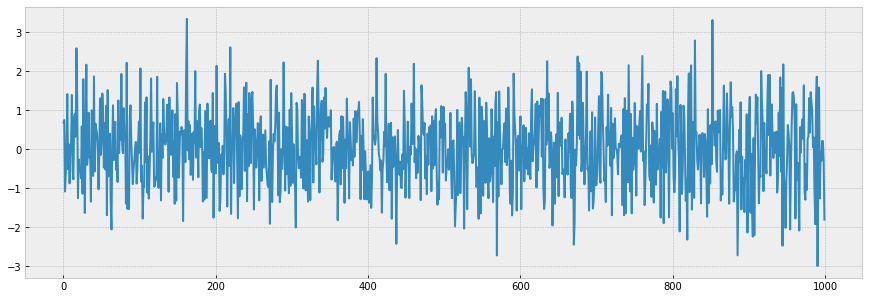

In [23]:
import numpy as np
import matplotlib.pyplot as plt
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)
plt.show()

/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


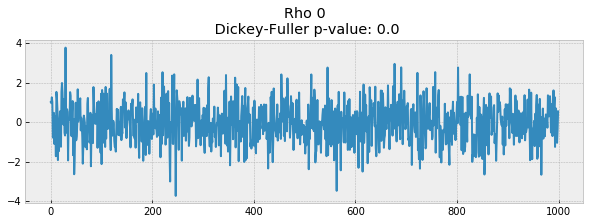

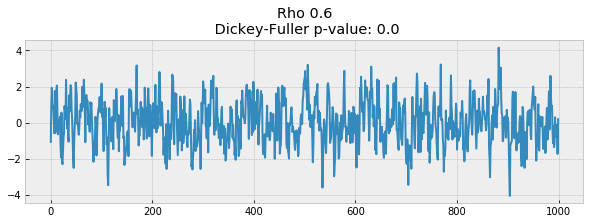

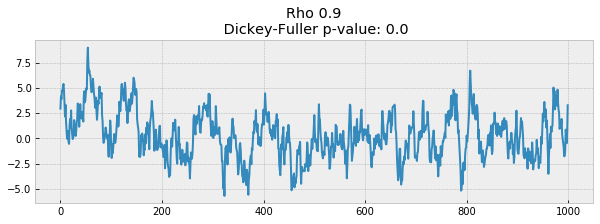

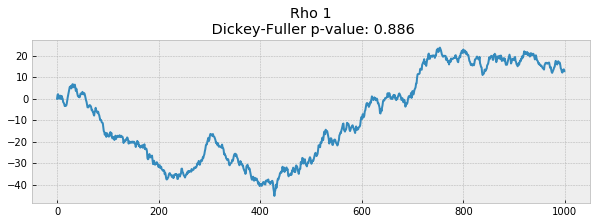

In [25]:
import statsmodels.api as sm
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))

for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)